<a href="https://colab.research.google.com/github/gb999/LuaLuaLua/blob/visualization/LuaLuaLua.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the data

1. To download competition data from Kaggle the rules of the competition have to be accepted [here](https://www.kaggle.com/competitions/nlp-getting-started/data), by joining the competition.

2. After that, an API key has to be obtained.
Follow these [instructions](https://www.kaggle.com/docs/api) to do so.

3. Create a new secret named `kaggle.json` in Google Colab, copy the contents of the downloaded file into the value field. Enable Notebook access, and you are ready to go.





In [2]:
from google.colab import userdata
import json, os
kaggle_path = '/root/.config/kaggle'
kaggle_json = userdata.get('kaggle.json')
os.makedirs(kaggle_path, exist_ok=True)

with open(kaggle_path + '/kaggle.json', 'w') as f:
    f.write(kaggle_json)

os.chmod(kaggle_path + '/kaggle.json', 0o600)


In [3]:
!pip install kaggle --quiet
!kaggle competitions download -c nlp-getting-started -q
!unzip -o nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Visualization


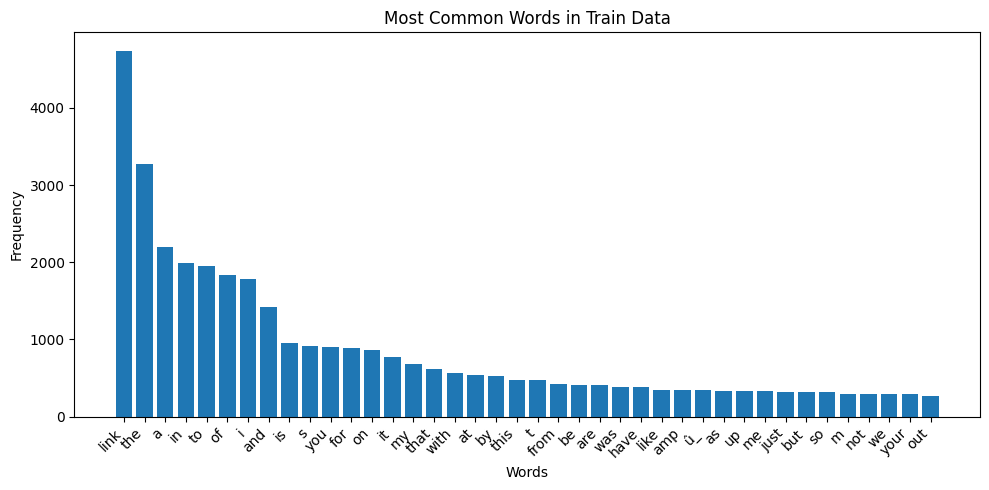

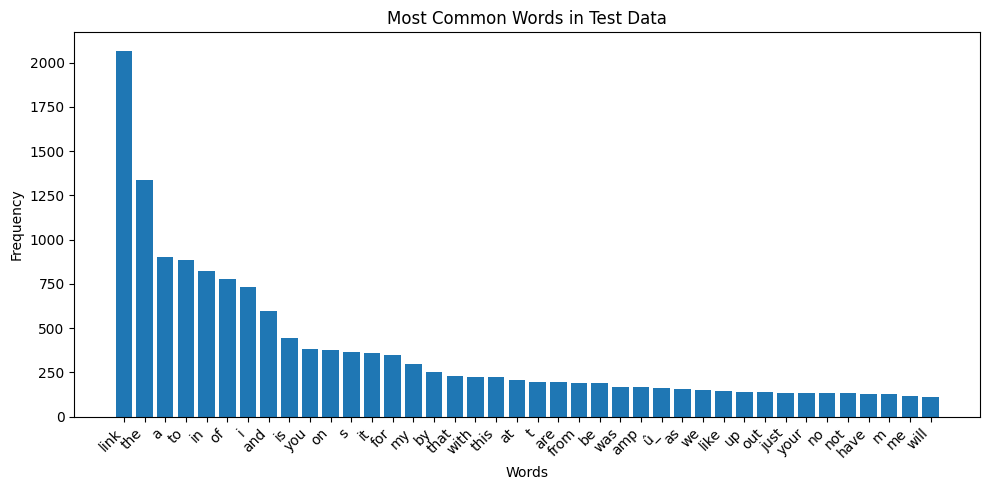

In [4]:
import pandas as pd
from collections import Counter
import re
import matplotlib.pyplot as plt

# Load DataFrames
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

def get_most_common_words(df, text_column, n=40):
    # Combine all text into a single string
    text = " ".join(df[text_column].astype(str).tolist())
    # Remove any special characters and split into words
    words = re.findall(r'\w+', text.lower())
    # Count the frequency of each word
    word_counts = Counter(words)
    # Get the n most common words
    return word_counts.most_common(n)

def plot_most_common_words(common_words, title):
  """Plots the most common words and their frequencies.

  Args:
    common_words: A list of tuples, where each tuple contains a word and its frequency.
    title: The title of the plot.
  """
  words, counts = zip(*common_words)  # Unzip the tuples
  plt.figure(figsize=(10, 5))  # Adjust figure size if needed
  plt.bar(words, counts)
  plt.title(title)
  plt.xlabel("Words")
  plt.ylabel("Frequency")
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent labels from overlapping
  plt.show()

def remove_links(text,replace=''):
  """Removes links from a text string.

  Args:
    text: The input text string.

  Returns:
    The text string with links removed.
  """
  # Remove links using regular expression
  text = re.sub(r'http\S+', replace, text)
  return text

pd.set_option("display.max_colwidth", None)

# Remove links from data
train_df['text'] = train_df['text'].apply(lambda x: remove_links(x, replace="[link]"))  # Replace with space
test_df['text'] = test_df['text'].apply(lambda x: remove_links(x, replace="[link]"))  # Replace with space

# Count @-s
# For train_df
#at_count_train = train_df['text'].str.count('@').sum()
#print(f"Number of '@' in train_df: {at_count_train}")

# For test_df
#at_count_test = test_df['text'].str.count('@').sum()
#print(f"Number of '@' in test_df: {at_count_test}")

# First 10 entries with "@"
# Filter for entries containing "@"
#at_entries = train_df[train_df['text'].str.contains('@')]

# Print the first 10 entries
#print(at_entries.head(10))



# Get most common words
train_common_words = get_most_common_words(train_df, 'text') # Updated column name
test_common_words = get_most_common_words(test_df, 'text') # Updated column name

# Diagrams
plot_most_common_words(train_common_words, "Most Common Words in Train Data")
plot_most_common_words(test_common_words, "Most Common Words in Test Data")

#print(train_df.iloc[7610])

#print(train_df)
#print(test_df.shape)
#print(train_df.iloc[40])

# Notes for visualization (THIS IS TEMPRARY, DO NOT MERGE WITH THIS!!!!)

## DONE
- display most common words
- remove links (words starting with http)

## TODO
- "û_" és "t" common words
- RT @ és @ words need handling
- handle dates


# Encoding the data

Text cleaning is an essential preprocessing step in word vectorization, as it removes noise that can interfere with meaningful analysis. This often includes eliminating stopwords and punctuation, which don't add significant value to word embeddings, and converting text to lowercase to ensure consistency across words. By focusing on essential terms, this cleaning process enhances the quality and accuracy of word vector models.

In [6]:
!pip install nltk --quiet

In [5]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

lines = train_df['text']
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_lines(lines, remove_stopwords=True, stop_words=set()):
  cleaned_lines = []
  for line in lines:
    words = re.findall(r"[A-Za-z]+", line.lower()) # Keep letters only

    if remove_stopwords:
      words = [word for word in words if word not in stop_words]

    cleaned_line = ' '.join(words)
    cleaned_lines.append(cleaned_line)

  return cleaned_lines


cleaned_lines = clean_lines(lines, True, stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
!wget -nc -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -n glove.6B.zip

^C
Archive:  glove.6B.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of glove.6B.zip or
        glove.6B.zip.zip, and cannot find glove.6B.zip.ZIP, period.


# GloVe
GloVe, which stands for Global Vectors for Word Representation, is a popular word embedding technique that captures semantic relationships between words in a vector space. This model is a straightforward word-vectorization model, which uses a 100-dimensional vector for each word. In this model (as in other word-vector models), each word is represented by an
n-dimensional vector. The "distance" between vectors represents the similarity between words. Distance is calculated using the Pythagorean theorem, as the square root of the sum of squared differences. For instance, the distance between words like "mug" and "cup" is small, as they are similar and can often be used interchangeably in a sentence. However, words like "tractor" and "skyscraper" are positioned far apart in the vector space due to their distinct meanings.

There are, of course, other word-to-vector models, but we chose GloVe for our initial attempt due to its simplicity and ease of use. We will train our first prediction model using this. Later, to potentially improve accuracy, we may switch to Word2Vec, which can use vectors with dimensions of 100, 200, or even 300 for greater precision.

In [ ]:
import numpy as np
# Returns a word-vector dictionary
def load_glove_model(file_path):
  glove_model = {}
  with open(file_path, 'r', encoding='utf-8') as f:
    # assign a vector to each word
    for line in f:
      values = line.split(' ')
      word = values[0]
      vector = np.asarray(values[1:], dtype='float32')
      glove_model[word] = vector
  return glove_model

glove_path = 'glove.6B.100d.txt'
glove_model = load_glove_model(glove_path)

# Get vector for word 'python'
print(glove_model['python'])
print(f"length: {len(glove_model['python'])}")

[ 0.24934    0.68318   -0.044711  -1.3842    -0.0073079  0.651
 -0.33958   -0.19785   -0.33925    0.26691   -0.033062   0.15915
  0.89547    0.53999   -0.55817    0.46245    0.36722    0.1889
  0.83189    0.81421   -0.11835   -0.53463    0.24158   -0.038864
  1.1907     0.79353   -0.12308    0.6642    -0.77619   -0.45713
 -1.054     -0.20557   -0.13296    0.12239    0.88458    1.024
  0.32288    0.82105   -0.069367   0.024211  -0.51418    0.8727
  0.25759    0.91526   -0.64221    0.041159  -0.60208    0.54631
  0.66076    0.19796   -1.1393     0.79514    0.45966   -0.18463
 -0.64131   -0.24929   -0.40194   -0.50786    0.80579    0.53365
  0.52732    0.39247   -0.29884    0.009585   0.99953   -0.061279
  0.71936    0.32901   -0.052772   0.67135   -0.80251   -0.25789
  0.49615    0.48081   -0.68403   -0.012239   0.048201   0.29461
  0.20614    0.33556   -0.64167   -0.64708    0.13377   -0.12574
 -0.46382    1.3878     0.95636   -0.067869  -0.0017411  0.52965
  0.45668    0.61041   -0.115